### **Inspiration**: Diamant M, Baruch S, Kassem E, Muhsen K, Samet D, Leshno M, Obolski U. A game theoretic approach reveals that discretizing clinical information can reduce antibiotic misuse. Nat Commun. 2021 Feb 19;12(1):1148. doi: 10.1038/s41467-021-21088-5. PMID: 33608511; PMCID: PMC7895914.

### **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from scipy.stats import beta as beta_dist, gaussian_kde
from scipy.integrate import trapezoid
from typing import Tuple, Optional, List

In [2]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.utils import image_dataset_from_directory

### **Settings**

In [3]:
# Set global font to support Polish characters
plt.rcParams['font.family'] = 'DejaVu Sans'

### **Figure 2**

In [4]:
def calculate_E_p(pdf: np.ndarray, p_values: np.ndarray) -> float:
    """
    Calculates the overall expected value E[p] for a given PDF.

    E[p] = integral(p * f(p) dp) from 0 to 1.

    Args:
        pdf (np.ndarray): The probability density function values f(p).
        p_values (np.ndarray): The corresponding p values (from 0 to 1).

    Returns:
        float: The expected value E[p].
    """
    # Use trapezoidal rule for numerical integration
    return trapezoid(p_values * pdf, p_values)

In [5]:
def calculate_conditional_expectations(pdf: np.ndarray, 
                                     p_values: np.ndarray, 
                                     T: float) -> Tuple[float, float]:
    """
    Calculates the conditional expectations p_L and p_H for a given 
    threshold T.

    p_L = E[p | p < T] (Expected value for the "Low" group)
    p_H = E[p | p >= T] (Expected value for the "High" group)

    Args:
        pdf (np.ndarray): The probability density function values f(p).
        p_values (np.ndarray): The corresponding p values (from 0 to 1).
        T (float): The discretization threshold.

    Returns:
        Tuple[float, float]: A tuple containing (p_L, p_H).
    """
    # Find the index closest to the threshold T
    idx = np.searchsorted(p_values, T)

    # Split into "Low" (p < T) and "High" (p >= T) groups
    p_low, pdf_low = p_values[:idx], pdf[:idx]
    p_high, pdf_high = p_values[idx:], pdf[idx:]

    # Calculate P(L) and P(H) (the total probability mass for each group)
    P_L = trapezoid(pdf_low, p_low)
    P_H = trapezoid(pdf_high, p_high)

    # Calculate the unnormalized expectations
    E_L = trapezoid(p_low * pdf_low, p_low)
    E_H = trapezoid(p_high * pdf_high, p_high)

    # Calculate the conditional expectations p_L and p_H
    # Handle potential division by zero if P_L or P_H are (close to) 0
    p_L = E_L / P_L if P_L > 1e-9 else 0
    p_H = E_H / P_H if P_H > 1e-9 else 0

    return p_L, p_H

In [6]:
def find_first_crossing_T0(p_H_minus_p_L: np.ndarray, 
                           E_p: float, 
                           T_values: np.ndarray) -> Optional[float]:
    """
    Finds the first (minimal) threshold T0 where the stability condition
    p_H - p_L >= E_p is met.

    Args:
        p_H_minus_p_L (np.ndarray): Array of (p_H - p_L) values for each T.
        E_p (float): The overall expected value E[p].
        T_values (np.ndarray): The array of thresholds T that were tested.

    Returns:
        Optional[float]: The value of T0 if it exists, otherwise None.
    """
    # Find all indices where the red curve is above or on the black line
    crossing_indices = np.where(p_H_minus_p_L >= E_p)[0]
    
    if len(crossing_indices) > 0:
        # Return the first T value that satisfies the condition
        return T_values[crossing_indices[0]]
    
    # If the curve never crosses, return None
    return None

#### 1. Define the domain of p

In [7]:
# We use a small epsilon (1e-5) to avoid the p=0 and p=1 singularities
# of the U-shaped beta(0.5, 0.5) distribution.
p_values = np.linspace(1e-4, 1 - 1e-4, 1000)

#### 2. Define parameters for the 4 Beta distributions (a, b)

In [8]:
dist_params = [
    {'a': 0.5, 'b': 0.5, 'title': '(a) Rozkład U-kształtny'},
    {'a': 1, 'b': 1, 'title': '(b) Rozkład jednostajny'},
    {'a': 1.5, 'b': 5, 'title': '(c) Rozkład skośny'},
    {'a': 5, 'b': 5, 'title': '(d) Rozkład dzwonowy'}
]

#### 3. Create the plot grid and loop through the 4 distributions

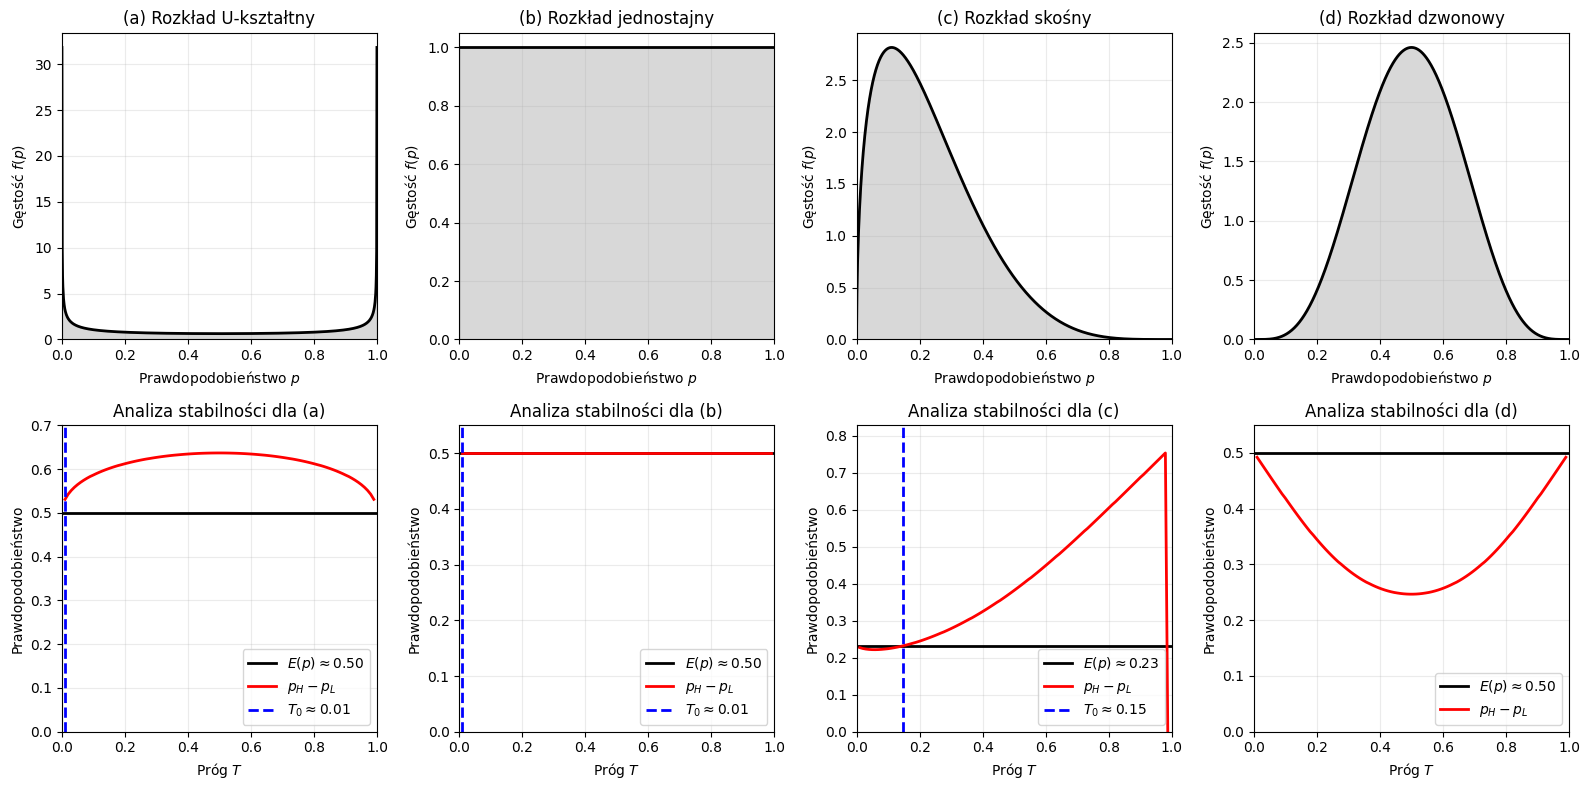

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, params in enumerate(dist_params):
    a, b = params['a'], params['b']
    dist = beta_dist(a, b)
    pdf = dist.pdf(p_values)
    
    # --- PDF plot (top row) ---
    ax_pdf = axes[0, i]
    ax_pdf.plot(p_values, pdf, 'k-', lw=2)
    ax_pdf.fill_between(p_values, pdf, color='gray', alpha=0.3)
    ax_pdf.set_title(params['title'])
    ax_pdf.set_xlabel('Prawdopodobieństwo $p$')
    ax_pdf.set_ylabel('Gęstość $f(p)$')
    ax_pdf.set_xlim(0, 1) # Still plot from 0 to 1
    ax_pdf.set_ylim(bottom=0)
    ax_pdf.grid(alpha=0.25)

    # --- Stability analysis plot (bottom row) ---
    ax_stability = axes[1, i]
    
    # Calculate the constant E[p]
    E_p_val = calculate_E_p(pdf, p_values)
    
    # Test different thresholds T
    T_values = np.linspace(0.01, 0.99, 100)
    p_H_minus_p_L = []

    for T in T_values:
        p_L, p_H = calculate_conditional_expectations(pdf, p_values, T)
        p_H_minus_p_L.append(p_H - p_L)
    
    p_H_minus_p_L = np.array(p_H_minus_p_L)

    # Plot E[p] (black line)
    ax_stability.axhline(E_p_val, color='black', linestyle='-', lw=2,
                         label=f'$E(p) \\approx {E_p_val:.2f}$')
    
    # Plot p_H - p_L (red curve)
    ax_stability.plot(T_values, p_H_minus_p_L, color='red', lw=2, label='$p_H - p_L$')

    # Find and draw T0 (minimal stability threshold)
    T0 = find_first_crossing_T0(p_H_minus_p_L, E_p_val, T_values)
    
    if T0 is not None:
        ax_stability.axvline(T0, color='blue', linestyle='--', lw=2, label=f'$T_0 \\approx {T0:.2f}$')
        
    # Calculate the upper limit for the y-axis with a 10% margin
    # To prevent the plot from clipping
    y_max_data = max(np.max(p_H_minus_p_L), E_p_val)
    y_top_limit = y_max_data * 1.1

    # Set axis labels and legend
    ax_stability.set_title(f'Analiza stabilności dla {params["title"][0:3]}')
    ax_stability.set_xlabel('Próg $T$')
    ax_stability.set_ylabel('Prawdopodobieństwo')
    ax_stability.set_xlim(0, 1)
    # Apply the new y-limits (bottom and top)
    ax_stability.set_ylim(bottom=0, top=y_top_limit) 
    ax_stability.legend(loc='lower right')
    ax_stability.grid(alpha=0.25)

plt.tight_layout()
plt.show()

### **Training model on chest x-ray data**

In [10]:
# --- 1.1: Setup data paths and parameters ---

script_dir = os.getcwd()
DATA_DIR = os.path.join(script_dir, 'data', 'chest_xray')

train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')
test_dir = os.path.join(DATA_DIR, 'test')

# Image parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 3

In [11]:
# --- 1.2: Load datasets ---
# We now use 'categorical' label mode for 3 classes

print("Loading training data (3-Class: NORMAL, VIRAL, BACTERIAL)...")
train_ds = image_dataset_from_directory(
    train_dir,
    label_mode='categorical', 
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

print("Loading validation data...")
val_ds = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

print("Loading test data...")
test_ds = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    shuffle=False 
)

Loading training data (3-Class: NORMAL, VIRAL, BACTERIAL)...
Found 5216 files belonging to 3 classes.
Loading validation data...
Found 16 files belonging to 3 classes.
Loading test data...
Found 624 files belonging to 3 classes.


In [12]:
class_names: List[str] = train_ds.class_names
bacterial_index: int = class_names.index('BACTERIAL')

print(f"Znaleziono klasy: {class_names}")
print(f"Indeks dla 'BACTERIAL' to: {bacterial_index}")

Znaleziono klasy: ['BACTERIAL', 'NORMAL', 'VIRAL']
Indeks dla 'BACTERIAL' to: 0


In [13]:
# --- 1.3: Normalize data ---
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
# --- 1.4: Build a 3-Class CNN model ---
model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax') # 3 wyjścia
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Właściwa strata dla 3 klas
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 858,819 (3.28 MB)

 Trainable params: 858,819 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# --- 1.5: Train the model ---
print("\nStarting 3-class model training...")
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)
print("Training finished.")


Starting 3-class model training...
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.6459 - loss: 0.7679 - val_accuracy: 0.6250 - val_loss: 0.6715
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.7596 - loss: 0.5611 - val_accuracy: 0.5000 - val_loss: 0.9008
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.7648 - loss: 0.5315 - val_accuracy: 0.5000 - val_loss: 1.1431
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.7761 - loss: 0.4946 - val_accuracy: 0.6875 - val_loss: 0.7674
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.7841 - loss: 0.4790 - val_accuracy: 0.5625 - val_loss: 0.8867
Training finished.


In [16]:
# --- 1.6: Generate the empirical probabilities 'p' ---
print("Generating 3-class probabilities from the test set...")
# predict() zwróci tablicę [N_próbek, 3]
all_probabilities = model.predict(test_ds)

p_data_empirical = all_probabilities[:, bacterial_index] 

# Clip for numerical stability
p_data_empirical = np.clip(p_data_empirical, 1e-5, 1 - 1e-5)

print(f"Extracted {len(p_data_empirical)} probabilities for P(Bacterial).")

Generating 3-class probabilities from the test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Extracted 624 probabilities for P(Bacterial).


Starting stability analysis on P(Bacterial) predictions...
Analiza: Nie znaleziono stabilnego progu T0.


<>:18: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:18: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\h'
C:\Users\filip\AppData\Local\Temp\ipykernel_1388\1020930751.py:18: SyntaxWarning: invalid escape sequence '\h'
  ax_pdf.set_title('Empiryczny rozkład $\hat{f}(p)$ (Model 3-klasowy)')
C:\Users\filip\AppData\Local\Temp\ipykernel_1388\1020930751.py:19: SyntaxWarning: invalid escape sequence '\h'
  ax_pdf.set_ylabel('Gęstość $\hat{f}(p)$')


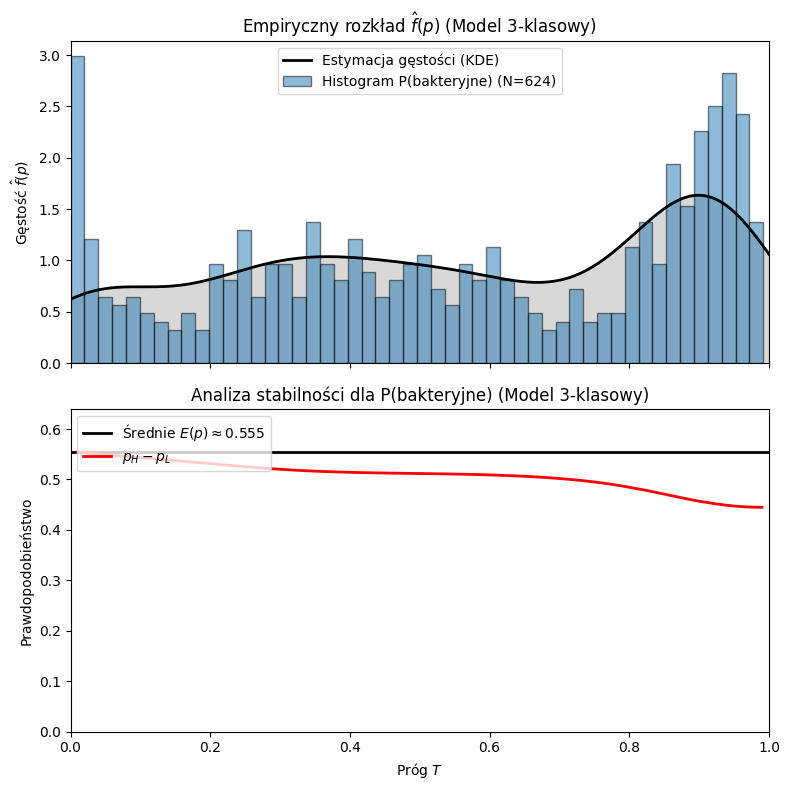

In [17]:
# --- 2.2: Perform analysis on the 3-class P(Bacterial) predictions ---
print("Starting stability analysis on P(Bacterial) predictions...")

p_values_domain = np.linspace(0, 1, 1000)
kde = gaussian_kde(p_data_empirical)
pdf_empirical = kde.pdf(p_values_domain)
pdf_empirical /= trapezoid(pdf_empirical, p_values_domain)

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# --- Top Panel: Empirical PDF f_hat(p) ---
ax_pdf = axes[0]
ax_pdf.plot(p_values_domain, pdf_empirical, 'k-', lw=2, 
            label='Estymacja gęstości (KDE)')
ax_pdf.fill_between(p_values_domain, pdf_empirical, color='gray', alpha=0.3)
ax_pdf.hist(p_data_empirical, bins=50, density=True, alpha=0.5, 
            edgecolor='black', label=f'Histogram P(bakteryjne) (N={len(p_data_empirical)})')
ax_pdf.set_title('Empiryczny rozkład $\hat{f}(p)$ (Model 3-klasowy)')
ax_pdf.set_ylabel('Gęstość $\hat{f}(p)$')
ax_pdf.set_xlim(0, 1)
ax_pdf.set_ylim(bottom=0)
ax_pdf.legend()

# --- Bottom Panel: Stability Analysis ---
ax_stability = axes[1]
E_p_val = calculate_E_p(pdf_empirical, p_values_domain)
T_values = np.linspace(0.01, 0.99, 100)
p_H_minus_p_L = []
for T in T_values:
    p_L, p_H = calculate_conditional_expectations(pdf_empirical, 
                                                p_values_domain, T)
    p_H_minus_p_L.append(p_H - p_L)
p_H_minus_p_L = np.array(p_H_minus_p_L)

ax_stability.axhline(E_p_val, color='black', linestyle='-', lw=2, 
                     label=f'Średnie $E(p) \\approx {E_p_val:.3f}$')
ax_stability.plot(T_values, p_H_minus_p_L, color='red', lw=2, 
                  label='$p_H - p_L$')
T0 = find_first_crossing_T0(p_H_minus_p_L, E_p_val, T_values)

if T0 is not None:
    ax_stability.axvline(T0, color='blue', linestyle='--', lw=2, 
                         label=f'Stabilny próg $T_0 \\approx {T0:.3f}$')
else:
    print("Analiza: Nie znaleziono stabilnego progu T0.")

ax_stability.set_title('Analiza stabilności dla P(bakteryjne) (Model 3-klasowy)')
ax_stability.set_xlabel('Próg $T$')
ax_stability.set_ylabel('Prawdopodobieństwo')
ax_stability.set_xlim(0, 1)
y_max_data = max(np.max(p_H_minus_p_L), E_p_val)
y_top_limit = y_max_data * 1.15 if y_max_data > 0 else 0.1 
ax_stability.set_ylim(bottom=0, top=y_top_limit)
ax_stability.legend(loc='upper left')

plt.tight_layout()
plt.show()

#### deleting part of bacterial pictures from test folder - creating the right skewed distributed model

In [57]:
# --- 1.1: Setup data paths and parameters ---

script_dir = os.getcwd()
DATA_DIR = os.path.join(script_dir, 'data', 'chest_xray_ill')

train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')
test_dir = os.path.join(DATA_DIR, 'test')

# Image parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 3

In [58]:
# --- 1.2: Load datasets ---
# We now use 'categorical' label mode for 3 classes

print("Loading training data (3-Class: NORMAL, VIRAL, BACTERIAL)...")
train_ds = image_dataset_from_directory(
    train_dir,
    label_mode='categorical', 
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

print("Loading validation data...")
val_ds = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

print("Loading test data...")
test_ds = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    shuffle=False 
)

Loading training data (3-Class: NORMAL, VIRAL, BACTERIAL)...
Found 5216 files belonging to 3 classes.
Loading validation data...
Found 16 files belonging to 3 classes.
Loading test data...
Found 434 files belonging to 3 classes.


In [59]:
class_names: List[str] = train_ds.class_names
bacterial_index: int = class_names.index('BACTERIAL')

print(f"Znaleziono klasy: {class_names}")
print(f"Indeks dla 'BACTERIAL' to: {bacterial_index}")

Znaleziono klasy: ['BACTERIAL', 'NORMAL', 'VIRAL']
Indeks dla 'BACTERIAL' to: 0


In [60]:
# --- 1.3: Normalize data ---
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [61]:
# --- 1.4: Build a 3-Class CNN model ---
model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax') # 3 wyjścia
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Właściwa strata dla 3 klas
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 858,819 (3.28 MB)

 Trainable params: 858,819 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# --- 1.5: Train the model ---
print("\nStarting 3-class model training...")
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)
print("Training finished.")


Starting 3-class model training...
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.6223 - loss: 0.8231 - val_accuracy: 0.5000 - val_loss: 0.8946
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 210ms/step - accuracy: 0.7260 - loss: 0.6153 - val_accuracy: 0.4375 - val_loss: 0.8907
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.7467 - loss: 0.5564 - val_accuracy: 0.6250 - val_loss: 0.5678
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.7600 - loss: 0.5355 - val_accuracy: 0.5625 - val_loss: 0.7247
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.7728 - loss: 0.5130 - val_accuracy: 0.5000 - val_loss: 0.8507
Training finished.


In [63]:
# --- 1.6: Generate the empirical probabilities 'p' ---
print("Generating 3-class probabilities from the test set...")
# predict() zwróci tablicę [N_próbek, 3]
all_probabilities = model.predict(test_ds)

p_data_empirical = all_probabilities[:, bacterial_index] 

# Clip for numerical stability
p_data_empirical = np.clip(p_data_empirical, 1e-5, 1 - 1e-5)

print(f"Extracted {len(p_data_empirical)} probabilities for P(Bacterial).")

Generating 3-class probabilities from the test set...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Extracted 434 probabilities for P(Bacterial).


Starting stability analysis on P(Bacterial) predictions...


<>:18: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:18: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\h'
C:\Users\filip\AppData\Local\Temp\ipykernel_1388\1020930751.py:18: SyntaxWarning: invalid escape sequence '\h'
  ax_pdf.set_title('Empiryczny rozkład $\hat{f}(p)$ (Model 3-klasowy)')
C:\Users\filip\AppData\Local\Temp\ipykernel_1388\1020930751.py:19: SyntaxWarning: invalid escape sequence '\h'
  ax_pdf.set_ylabel('Gęstość $\hat{f}(p)$')


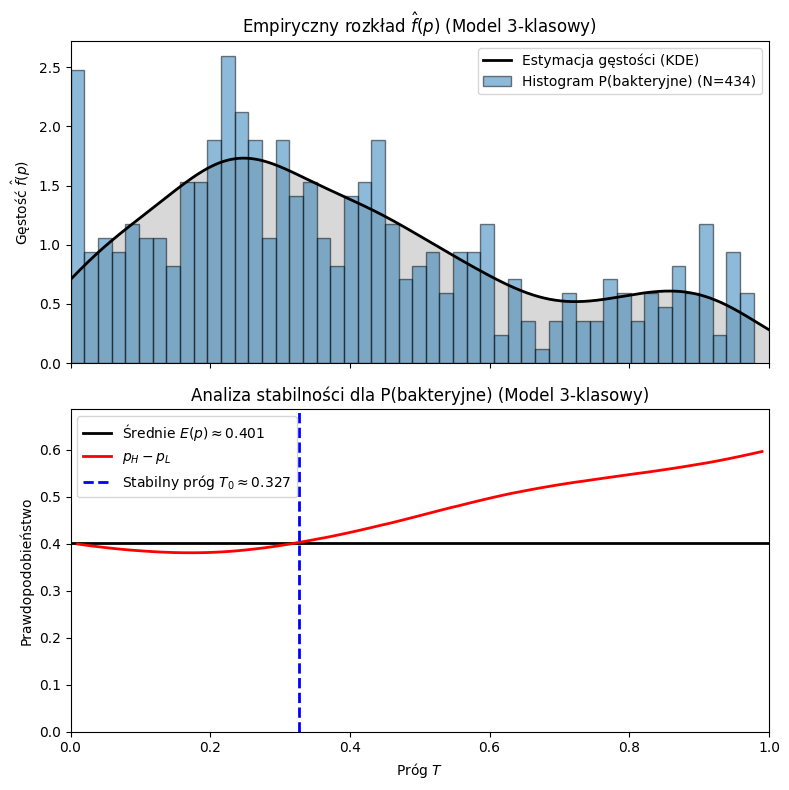

In [64]:
# --- 2.2: Perform analysis on the 3-class P(Bacterial) predictions ---
print("Starting stability analysis on P(Bacterial) predictions...")

p_values_domain = np.linspace(0, 1, 1000)
kde = gaussian_kde(p_data_empirical)
pdf_empirical = kde.pdf(p_values_domain)
pdf_empirical /= trapezoid(pdf_empirical, p_values_domain)

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# --- Top Panel: Empirical PDF f_hat(p) ---
ax_pdf = axes[0]
ax_pdf.plot(p_values_domain, pdf_empirical, 'k-', lw=2, 
            label='Estymacja gęstości (KDE)')
ax_pdf.fill_between(p_values_domain, pdf_empirical, color='gray', alpha=0.3)
ax_pdf.hist(p_data_empirical, bins=50, density=True, alpha=0.5, 
            edgecolor='black', label=f'Histogram P(bakteryjne) (N={len(p_data_empirical)})')
ax_pdf.set_title('Empiryczny rozkład $\hat{f}(p)$ (Model 3-klasowy)')
ax_pdf.set_ylabel('Gęstość $\hat{f}(p)$')
ax_pdf.set_xlim(0, 1)
ax_pdf.set_ylim(bottom=0)
ax_pdf.legend()

# --- Bottom Panel: Stability Analysis ---
ax_stability = axes[1]
E_p_val = calculate_E_p(pdf_empirical, p_values_domain)
T_values = np.linspace(0.01, 0.99, 100)
p_H_minus_p_L = []
for T in T_values:
    p_L, p_H = calculate_conditional_expectations(pdf_empirical, 
                                                p_values_domain, T)
    p_H_minus_p_L.append(p_H - p_L)
p_H_minus_p_L = np.array(p_H_minus_p_L)

ax_stability.axhline(E_p_val, color='black', linestyle='-', lw=2, 
                     label=f'Średnie $E(p) \\approx {E_p_val:.3f}$')
ax_stability.plot(T_values, p_H_minus_p_L, color='red', lw=2, 
                  label='$p_H - p_L$')
T0 = find_first_crossing_T0(p_H_minus_p_L, E_p_val, T_values)

if T0 is not None:
    ax_stability.axvline(T0, color='blue', linestyle='--', lw=2, 
                         label=f'Stabilny próg $T_0 \\approx {T0:.3f}$')
else:
    print("Analiza: Nie znaleziono stabilnego progu T0.")

ax_stability.set_title('Analiza stabilności dla P(bakteryjne) (Model 3-klasowy)')
ax_stability.set_xlabel('Próg $T$')
ax_stability.set_ylabel('Prawdopodobieństwo')
ax_stability.set_xlim(0, 1)
y_max_data = max(np.max(p_H_minus_p_L), E_p_val)
y_top_limit = y_max_data * 1.15 if y_max_data > 0 else 0.1 
ax_stability.set_ylim(bottom=0, top=y_top_limit)
ax_stability.legend(loc='upper left')

plt.tight_layout()
plt.show()